In [1]:
### Proyecto: Clasificación de Sesiones de Compra en E-commerce
### Modelo: Ensemble (VotingClassifier con CatBoost, XGBoost y RandomForest con Optuna)

# ----------------------------
# 1. CARGA DE LIBRERÍAS
# ----------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
import optuna
import warnings
warnings.filterwarnings('ignore')

# ----------------------------
# 2. CARGA DEL DATASET
# ----------------------------
df = pd.read_csv("data/online_shoppers_intention.csv")

# ----------------------------
# 3. PREPROCESAMIENTO Y NUEVAS FEATURES
# ----------------------------

In [2]:
print("Valores nulos por columna:")
print(df.isnull().sum())


Valores nulos por columna:
Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64


In [3]:
df.dtypes

Administrative               int64
Administrative_Duration    float64
Informational                int64
Informational_Duration     float64
ProductRelated               int64
ProductRelated_Duration    float64
BounceRates                float64
ExitRates                  float64
PageValues                 float64
SpecialDay                 float64
Month                       object
OperatingSystems             int64
Browser                      int64
Region                       int64
TrafficType                  int64
VisitorType                 object
Weekend                       bool
Revenue                       bool
dtype: object

In [4]:
# Contar valores únicos por columna
unique_counts = df.nunique().sort_values()

# Clasificación de variables
categorical_vars = []
numerical_vars = []

for col in df.columns:
    if df[col].dtype == 'object' or df[col].dtype == 'bool':
        categorical_vars.append(col)
    elif unique_counts[col] < 10:  # Pocas categorías -> probablemente categórica
        categorical_vars.append(col)
    else:
        numerical_vars.append(col)

# Mostrar resultados
print("Valores únicos por columna:\n", unique_counts)
print("\nVariables categóricas identificadas:")
print(categorical_vars)
print("\nVariables numéricas identificadas:")
print(numerical_vars)

Valores únicos por columna:
 Revenue                       2
Weekend                       2
VisitorType                   3
SpecialDay                    6
OperatingSystems              8
Region                        9
Month                        10
Browser                      13
Informational                17
TrafficType                  20
Administrative               27
ProductRelated              311
Informational_Duration     1258
BounceRates                1872
PageValues                 2704
Administrative_Duration    3335
ExitRates                  4777
ProductRelated_Duration    9551
dtype: int64

Variables categóricas identificadas:
['SpecialDay', 'Month', 'OperatingSystems', 'Region', 'VisitorType', 'Weekend', 'Revenue']

Variables numéricas identificadas:
['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues', 'Browser', 'TrafficType']


In [5]:
# Variables numéricas y categóricas basadas en la documentación
numerical_vars = [
    "Administrative", "Administrative_Duration", 
    "Informational", "Informational_Duration",
    "ProductRelated", "ProductRelated_Duration",
    "BounceRates", "ExitRates", "PageValues", "SpecialDay"
]

categorical_vars = [
    "Month", "OperatingSystems", "Browser", "Region",
    "TrafficType", "VisitorType", "Weekend", "Revenue"
]

print("Variables numéricas (10):", numerical_vars)
print("Variables categóricas (8):", categorical_vars)


Variables numéricas (10): ['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay']
Variables categóricas (8): ['Month', 'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType', 'Weekend', 'Revenue']


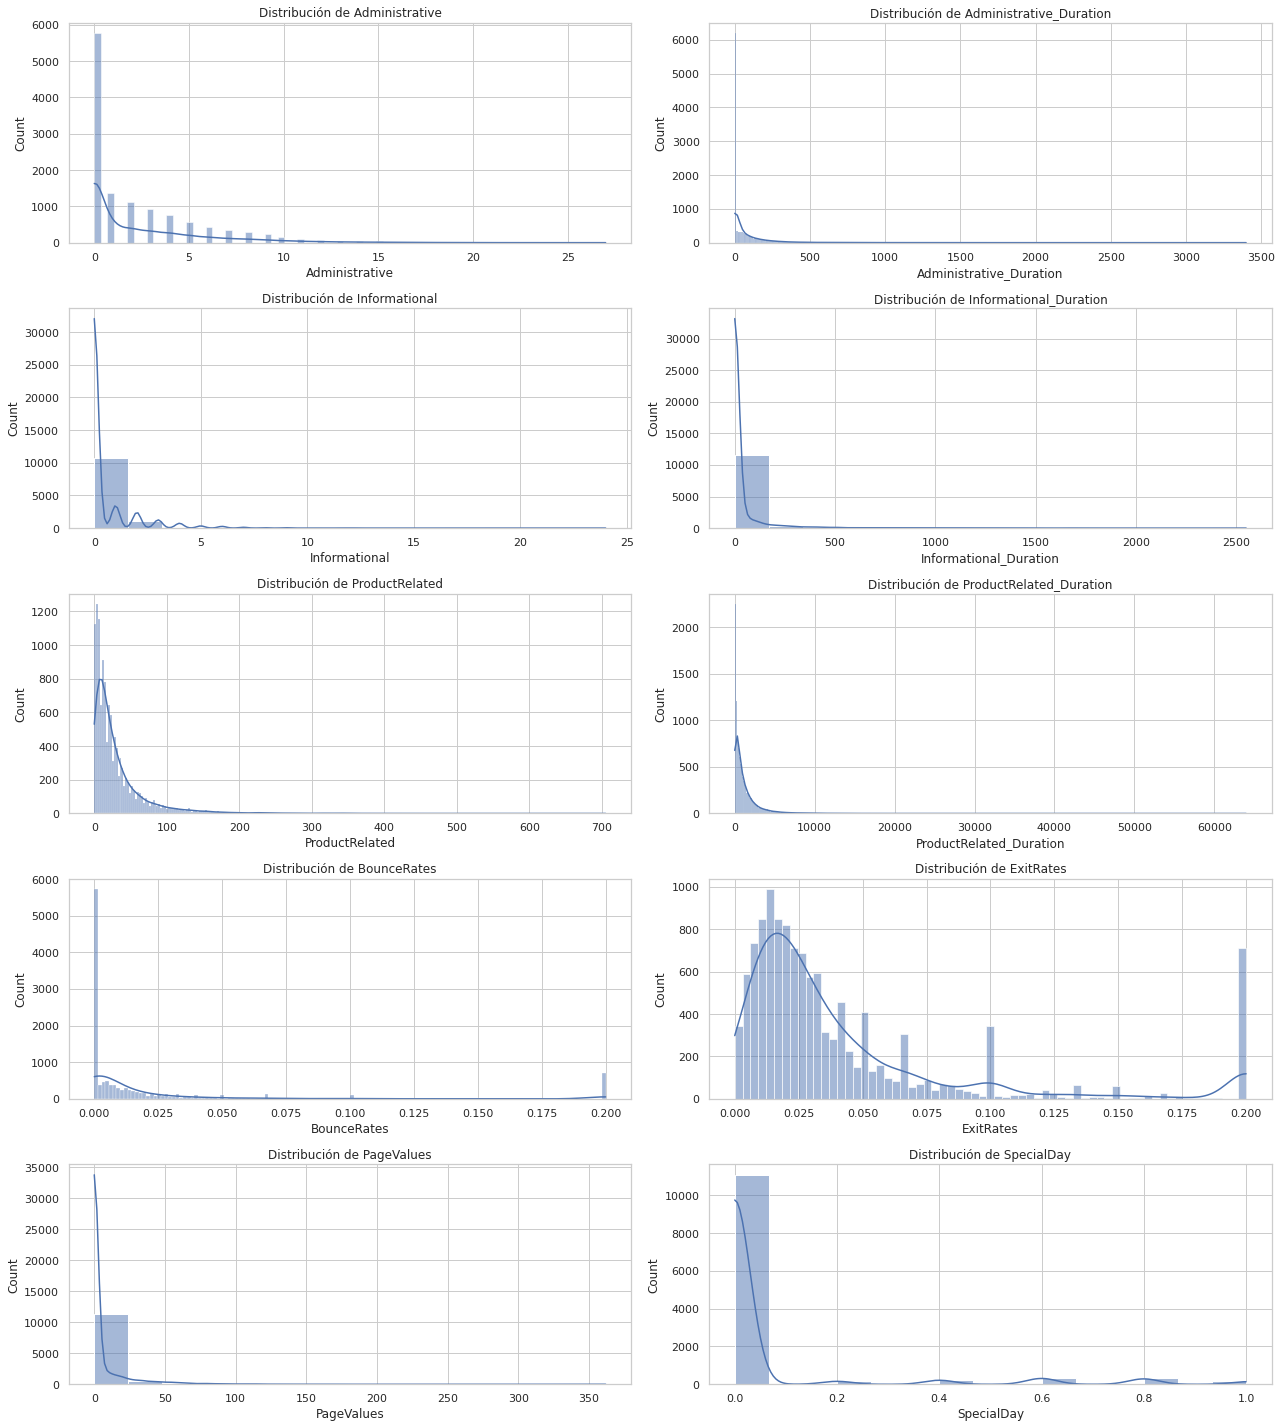

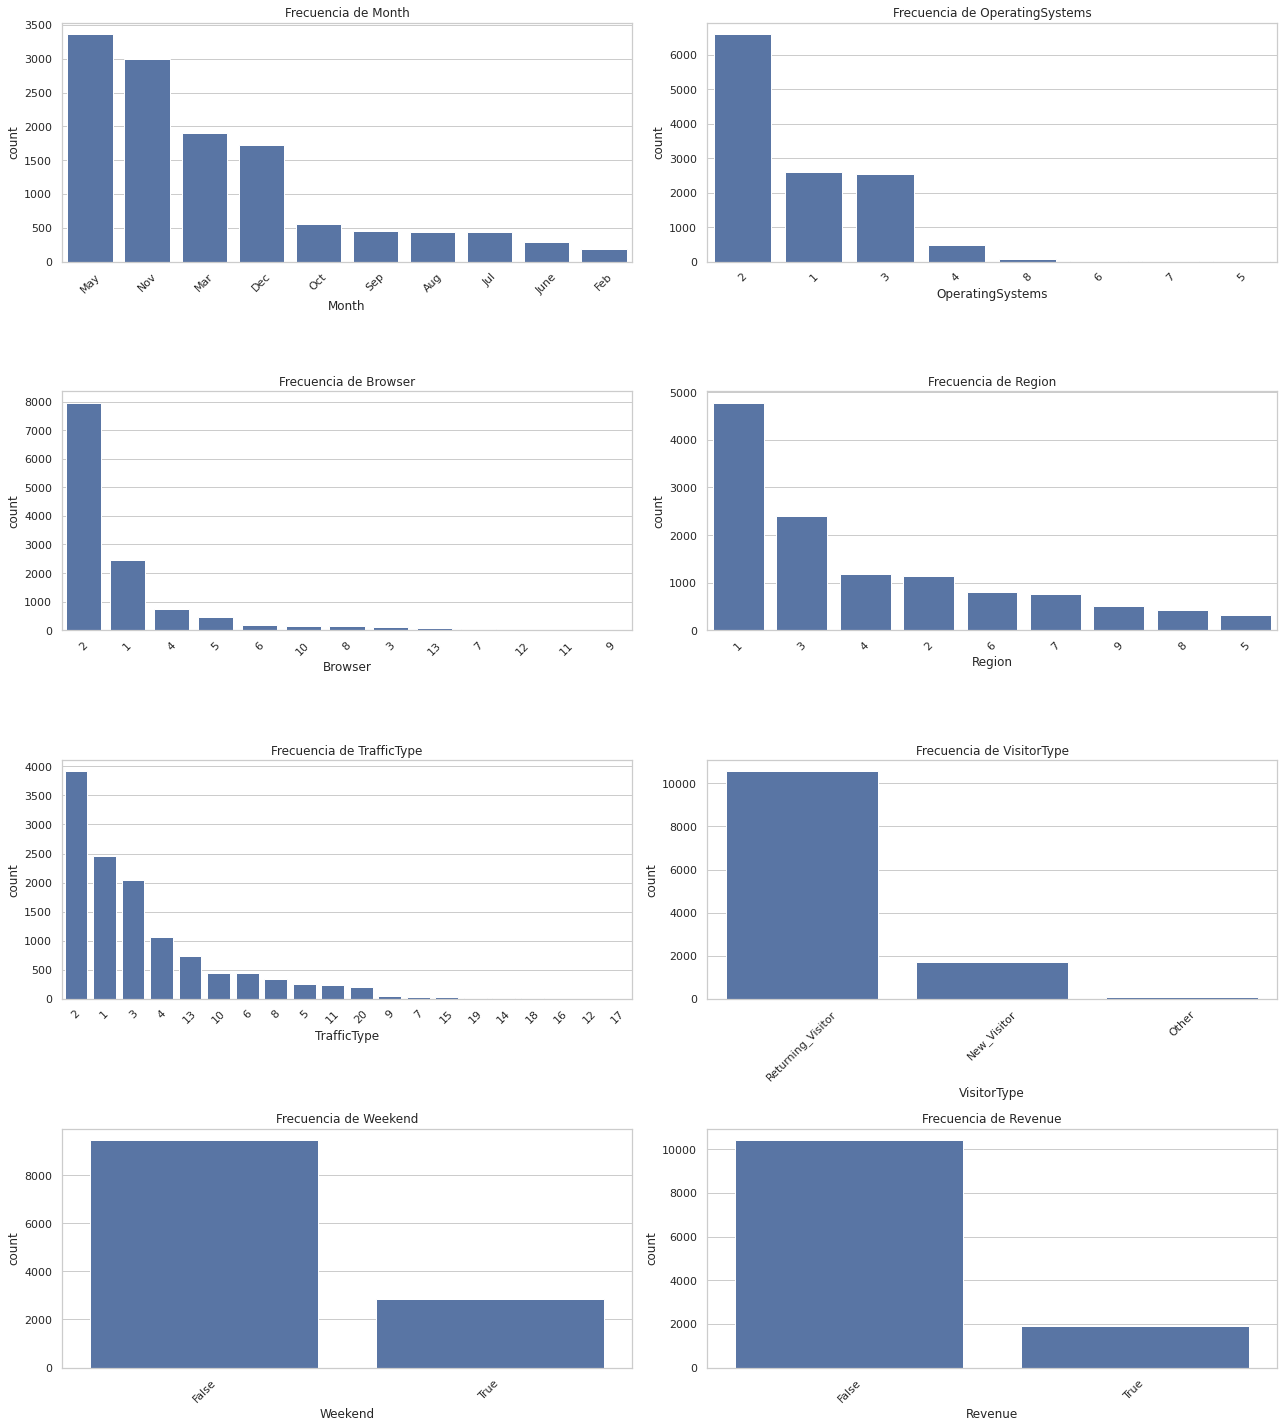

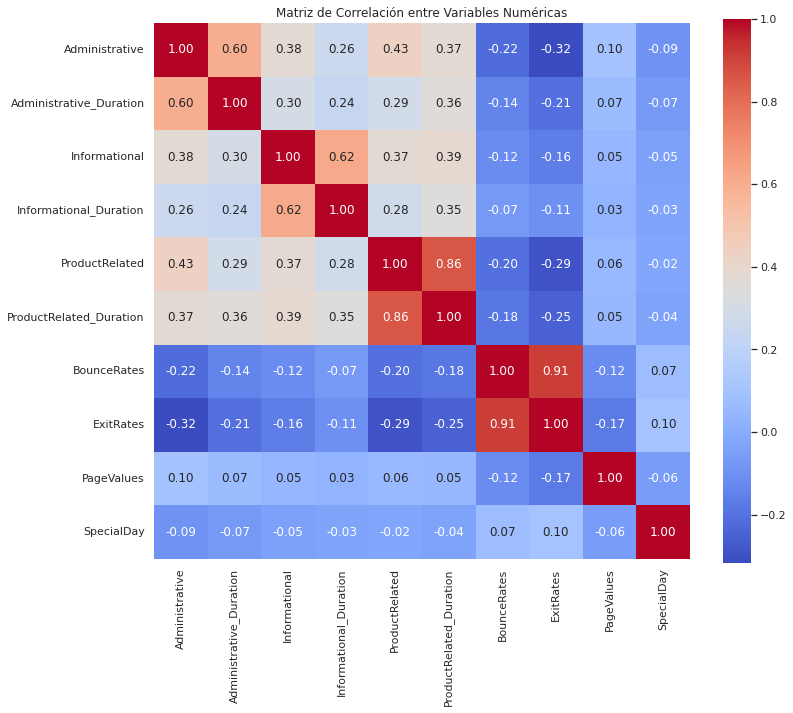

In [6]:
# Estilo
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

# --------- HISTOGRAMAS DE VARIABLES NUMÉRICAS ---------
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(18, 20))
for i, var in enumerate(numerical_vars):
    row, col = divmod(i, 2)
    sns.histplot(df[var], ax=axes[row][col], kde=True)
    axes[row][col].set_title(f"Distribución de {var}")
plt.tight_layout()
plt.show()

# --------- GRÁFICAS DE CONTEO DE CATEGÓRICAS ---------
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(18, 20))
for i, var in enumerate(categorical_vars):
    row, col = divmod(i, 2)
    sns.countplot(x=var, data=df, ax=axes[row][col], order=df[var].value_counts().index)
    axes[row][col].set_title(f"Frecuencia de {var}")
    axes[row][col].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()
plt.close()

# --------- MATRIZ DE CORRELACIÓN ---------
plt.figure(figsize=(12, 10))
corr = df[numerical_vars].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", square=True)
plt.title("Matriz de Correlación entre Variables Numéricas")
plt.show()
plt.close()



A partir de los histogramas generados, se observa que algunas variables numéricas presentan distribuciones sesgadas o colas largas (por ejemplo, PageValues y ProductRelated_Duration). En modelos sensibles a la escala y la distribución de los datos, como regresión lineal, KNN o SVM , estas características podrían requerir transformaciones (como normalización). Sin embargo, en este proyecto se emplean modelos basados en árboles de decisión (Random Forest, XGBoost, CatBoost), los cuales no dependen de la escala, la media o la varianza, y no utilizan distancias entre puntos. Por ello, no se aplican transformaciones ni truncamientos a los valores extremos.

La matriz de correlación muestra que algunas variables presentan colinealidad alta (mayor a 0.85), como ProductRelated y ProductRelated_Duration. En modelos lineales esto puede afectar la estabilidad de los coeficientes, pero los modelos basados en árboles no presentan esta limitación. Los árboles seleccionan las variables por su ganancia de información en cada división, y pueden ignorar o reutilizar variables correlacionadas si aportan valor adicional. No existe una penalización estadística por incluir variables redundantes.

Por lo tanto, no se eliminan variables por alta correlación, ya que los modelos utilizados están diseñados para manejar este tipo de relaciones de manera eficiente. Además, eliminar características de forma prematura podría reducir la capacidad predictiva del sistema.

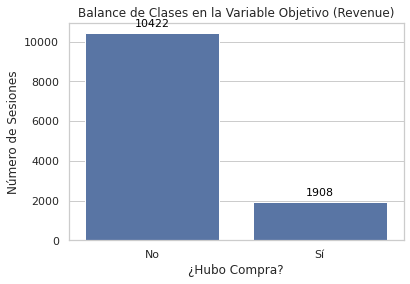

Distribución de la variable objetivo 'Revenue':
False    0.845255
True     0.154745
Name: Revenue, dtype: float64


In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Gráfico del balance de clases en Revenue con anotaciones
plt.figure(figsize=(6, 4))
ax = sns.countplot(x='Revenue', data=df)
plt.title("Balance de Clases en la Variable Objetivo (Revenue)")
plt.xlabel("¿Hubo Compra?")
plt.ylabel("Número de Sesiones")
plt.xticks(ticks=[0, 1], labels=["No", "Sí"])

# Añadir etiquetas con conteo
for p in ax.patches:
    count = int(p.get_height())
    ax.annotate(f'{count}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=11, color='black', xytext=(0, 10),
                textcoords='offset points')

plt.show()
plt.close()
# --------- BALANCE DE CLASES ---------
print("Distribución de la variable objetivo 'Revenue':")
print(df['Revenue'].value_counts(normalize=True))


La variable objetivo Revenue presenta un fuerte desbalance, con solo alrededor de 15.5% de sesiones que terminan en compra. Este desequilibrio será considerado para la selección de métricas de evaluación y en la interpretación del rendimiento de los modelos, ya que puede llevar a una alta exactitud aparente sin que el modelo realmente aprenda a identificar casos positivos.

In [8]:
from sklearn.preprocessing import LabelEncoder

df_processed = df.copy()

# 1. Codificar booleanas
df_processed['Revenue'] = df_processed['Revenue'].astype(int)
df_processed['Weekend'] = df_processed['Weekend'].astype(int)

# 2. One-hot encoding para nominales
df_processed = pd.get_dummies(df_processed, columns=['Month', 'VisitorType'], drop_first=True)

# 3. Label Encoding o dejar como está si son enteros ya
# En este caso, ya están como enteros: OperatingSystems, Browser, Region, TrafficType

# Mostrar las primeras filas del dataset procesado
df_processed.head()


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,...,Month_Feb,Month_Jul,Month_June,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep,VisitorType_Other,VisitorType_Returning_Visitor
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,...,1,0,0,0,0,0,0,0,0,1
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,...,1,0,0,0,0,0,0,0,0,1
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,...,1,0,0,0,0,0,0,0,0,1
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,...,1,0,0,0,0,0,0,0,0,1
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,...,1,0,0,0,0,0,0,0,0,1


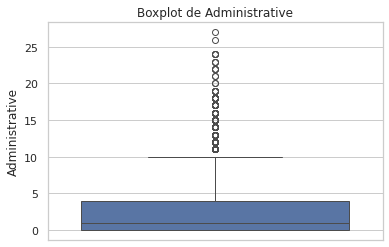

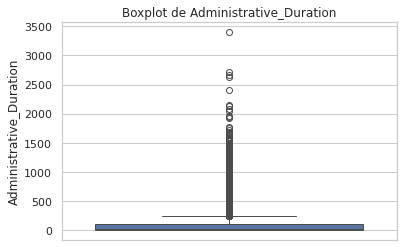

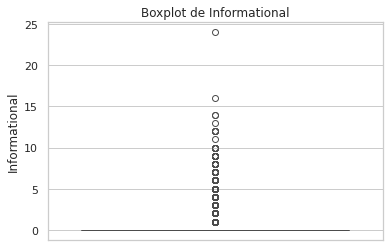

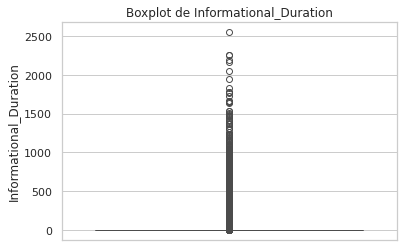

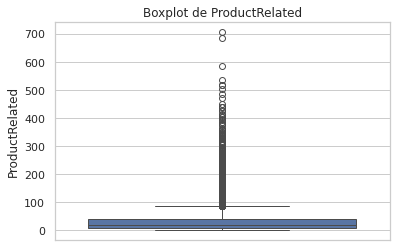

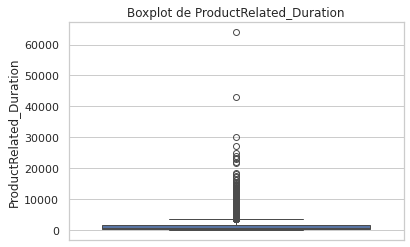

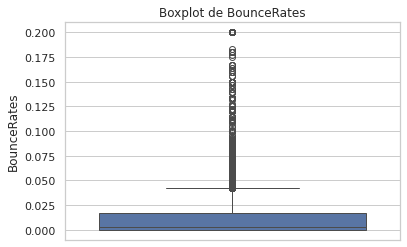

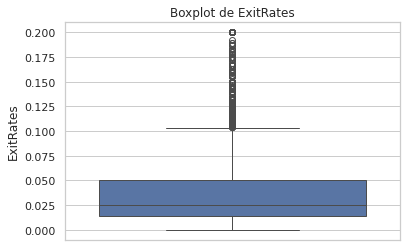

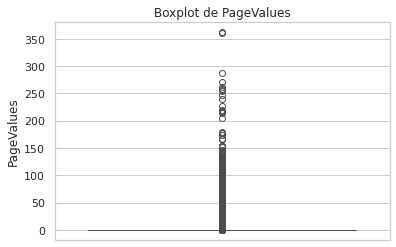

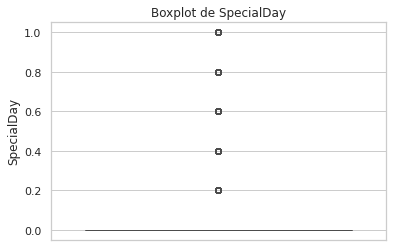

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Variables numéricas
numerical_vars = [
    "Administrative", "Administrative_Duration", 
    "Informational", "Informational_Duration",
    "ProductRelated", "ProductRelated_Duration",
    "BounceRates", "ExitRates", "PageValues", "SpecialDay"
]

# Boxplot individual por variable (sin Revenue)
for var in numerical_vars:
    plt.figure(figsize=(6, 4))
    sns.boxplot(y=df[var])
    plt.title(f"Boxplot de {var}")
    plt.ylabel(var)
    plt.show()
    plt.close()


In [10]:
df['Revenue'] = df['Revenue'].astype(int)
df['Weekend'] = df['Weekend'].astype(int)
df['ProductEffort'] = df['ProductRelated'] * df['ProductRelated_Duration']
df['BounceExitRatio'] = df['BounceRates'] / (df['ExitRates'] + 1e-6)
df_encoded = pd.get_dummies(df, columns=['Month', 'VisitorType'], drop_first=True)
X = df_encoded.drop('Revenue', axis=1)
y = df_encoded['Revenue']


In [11]:
# ----------------------------
# 4. SPLIT: TRAIN / VALID / TEST
# ----------------------------
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, stratify=y_temp, random_state=42)
# Se realiza el split en train test y validación

In [13]:
from sklearn.base import clone

def optimize_model(model_type, trial):
    if model_type == 'cat':
        params = {
            'iterations': trial.suggest_int('iterations', 100, 300),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
            'depth': trial.suggest_int('depth', 4, 10),
            'verbose': 0,
            'random_state': 42
        }
        return CatBoostClassifier(**params)
    
    elif model_type == 'xgb':
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 300),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
            'max_depth': trial.suggest_int('max_depth', 3, 7),  # más controlado
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),  # L1
            'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),  # L2
            'use_label_encoder': False,
            'eval_metric': 'logloss',
            'random_state': 42
        }
        return XGBClassifier(**params)
    
    elif model_type == 'rf':
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 300),
            'max_depth': trial.suggest_int('max_depth', 5, 15),
            'random_state': 42
        }
        return RandomForestClassifier(**params)


In [14]:
def run_optimization(model_type, n_trials=50):
    def objective(trial):
        model = optimize_model(model_type, trial)
        model.fit(X_train, y_train)
        preds = model.predict(X_val)
        report = classification_report(y_val, preds, output_dict=True)
        return report['1']['f1-score']  # optimizamos F1 de clase positiva

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials)
    print(f"Mejores hiperparámetros para {model_type.upper()}:", study.best_params)
    return optimize_model(model_type, optuna.trial.FixedTrial(study.best_params))


In [15]:
def evaluate_model_full(name, model, X_train, y_train, X_val, y_val):
    results = {'Modelo': name}

    for split, X, y in [('Train', X_train, y_train), ('Test', X_val, y_val)]:
        preds = model.predict(X)
        probas = model.predict_proba(X)[:, 1]
        report = classification_report(y, preds, output_dict=True)
        auc = roc_auc_score(y, probas)

        results[f'{split} Accuracy'] = report['accuracy']
        results[f'{split} F1-score (1)'] = report['1']['f1-score']
        results[f'{split} Precision (1)'] = report['1']['precision']
        results[f'{split} Recall (1)'] = report['1']['recall']
        results[f'{split} AUC'] = auc

    return results


In [16]:
from sklearn.metrics import confusion_matrix, RocCurveDisplay

def plot_confusion_and_roc(model, X_test, y_test, model_name):
    # Matriz de confusión
    fig, ax = plt.subplots(figsize=(6, 5))
    sns.heatmap(confusion_matrix(y_test, model.predict(X_test)), annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f"Matriz de Confusión - {model_name}")
    ax.set_xlabel("Predicción")
    ax.set_ylabel("Real")
    plt.tight_layout()
    plt.show()
    plt.close()

    # Curva ROC
    RocCurveDisplay.from_estimator(model, X_test, y_test)
    plt.title(f"Curva ROC - {model_name}")
    plt.show()
    plt.close()


In [17]:
# Entrenar y evaluar CatBoost
cat_model = run_optimization('cat', n_trials=100)
cat_model.fit(X_train, y_train)
cat_results = evaluate_model_full('CatBoost', cat_model, X_train, y_train, X_val, y_val)



[I 2025-06-17 07:22:25,927] A new study created in memory with name: no-name-c3f459b7-6d47-4b7c-8beb-93680619d58f
[I 2025-06-17 07:22:26,403] Trial 0 finished with value: 0.664323374340949 and parameters: {'iterations': 197, 'learning_rate': 0.08575159623068121, 'depth': 6}. Best is trial 0 with value: 0.664323374340949.
[I 2025-06-17 07:22:26,856] Trial 1 finished with value: 0.6368515205724508 and parameters: {'iterations': 217, 'learning_rate': 0.16764438085731953, 'depth': 6}. Best is trial 0 with value: 0.664323374340949.
[I 2025-06-17 07:22:27,224] Trial 2 finished with value: 0.6560283687943262 and parameters: {'iterations': 209, 'learning_rate': 0.0323850390746427, 'depth': 4}. Best is trial 0 with value: 0.664323374340949.
[I 2025-06-17 07:22:27,586] Trial 3 finished with value: 0.6749555950266429 and parameters: {'iterations': 171, 'learning_rate': 0.13376057374358355, 'depth': 6}. Best is trial 3 with value: 0.6749555950266429.
[I 2025-06-17 07:22:28,501] Trial 4 finished wi

Mejores hiperparámetros para CAT: {'iterations': 155, 'learning_rate': 0.1642503602701814, 'depth': 9}


In [18]:

# Entrenar y evaluar XGBoost
xgb_model = run_optimization('xgb', n_trials=100)
xgb_model.fit(X_train, y_train)
xgb_results = evaluate_model_full('XGBoost', xgb_model, X_train, y_train, X_val, y_val)



[I 2025-06-17 07:23:22,051] A new study created in memory with name: no-name-db84026e-9e91-40cc-b7f9-9085009089b0
[I 2025-06-17 07:23:22,408] Trial 0 finished with value: 0.657243816254417 and parameters: {'n_estimators': 284, 'learning_rate': 0.03427579154286501, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.6812818824189568, 'colsample_bytree': 0.7098330157619113, 'reg_alpha': 0.3617867049317778, 'reg_lambda': 0.32913169571158307}. Best is trial 0 with value: 0.657243816254417.
[I 2025-06-17 07:23:22,534] Trial 1 finished with value: 0.6631762652705061 and parameters: {'n_estimators': 104, 'learning_rate': 0.11447498832483531, 'max_depth': 5, 'min_child_weight': 3, 'subsample': 0.6580637536720341, 'colsample_bytree': 0.7479083090402252, 'reg_alpha': 0.9278409756352117, 'reg_lambda': 0.10669481386240887}. Best is trial 1 with value: 0.6631762652705061.
[I 2025-06-17 07:23:22,740] Trial 2 finished with value: 0.6536412078152753 and parameters: {'n_estimators': 196, 'learning_ra

Mejores hiperparámetros para XGB: {'n_estimators': 114, 'learning_rate': 0.06004674331420982, 'max_depth': 7, 'min_child_weight': 5, 'subsample': 0.8152264153280876, 'colsample_bytree': 0.8554884253826305, 'reg_alpha': 0.00333514577518039, 'reg_lambda': 0.4912262542429873}


In [19]:

# Entrenar y evaluar RandomForest
rf_model = run_optimization('rf', n_trials=100)
rf_model.fit(X_train, y_train)
rf_results = evaluate_model_full('RandomForest', rf_model, X_train, y_train, X_val, y_val)

[I 2025-06-17 07:23:41,839] A new study created in memory with name: no-name-73907b57-62bc-4818-b80f-5928b0fb051c
[I 2025-06-17 07:23:43,199] Trial 0 finished with value: 0.6363636363636364 and parameters: {'n_estimators': 286, 'max_depth': 8}. Best is trial 0 with value: 0.6363636363636364.
[I 2025-06-17 07:23:44,414] Trial 1 finished with value: 0.6389413988657845 and parameters: {'n_estimators': 255, 'max_depth': 8}. Best is trial 1 with value: 0.6389413988657845.
[I 2025-06-17 07:23:45,861] Trial 2 finished with value: 0.6378986866791745 and parameters: {'n_estimators': 282, 'max_depth': 9}. Best is trial 1 with value: 0.6389413988657845.
[I 2025-06-17 07:23:46,670] Trial 3 finished with value: 0.6424474187380497 and parameters: {'n_estimators': 168, 'max_depth': 8}. Best is trial 3 with value: 0.6424474187380497.
[I 2025-06-17 07:23:47,307] Trial 4 finished with value: 0.6407407407407407 and parameters: {'n_estimators': 110, 'max_depth': 11}. Best is trial 3 with value: 0.64244741

Mejores hiperparámetros para RF: {'n_estimators': 232, 'max_depth': 12}


In [20]:
# Crear DataFrame completo con todos los resultados
results_df = pd.DataFrame([cat_results, xgb_results, rf_results])
results_df = results_df.set_index('Modelo')

# Filtrar columnas de entrenamiento y prueba
train_metrics = results_df[[col for col in results_df.columns if col.startswith('Train')]]
test_metrics = results_df[[col for col in results_df.columns if col.startswith('Test')]]

# Mostrar las dos tablas
print("🔹 Métricas en TRAIN:")
display(train_metrics.round(3))

print("\n🔸 Métricas en TEST:")
display(test_metrics.round(3))


🔹 Métricas en TRAIN:


,Train Accuracy,Train F1-score (1),Train Precision (1),Train Recall (1),Train AUC
Modelo,,,,,
CatBoost,0.993,0.975,0.999,0.952,0.999
XGBoost,0.948,0.817,0.898,0.750,0.979
RandomForest,0.971,0.898,0.976,0.831,0.996



🔸 Métricas en TEST:


,Test Accuracy,Test F1-score (1),Test Precision (1),Test Recall (1),Test AUC
Modelo,,,,,
CatBoost,0.909,0.683,0.742,0.633,0.925
XGBoost,0.907,0.677,0.728,0.633,0.934
RandomForest,0.906,0.663,0.746,0.597,0.934


Se observa que, en general, los modelos presentan cierto overfitting. Sobretodo CatBoost que, si bien obtiene mejores resultados, se evidencia un mayor overfitting por la diferencia entre las métricas obtenidas en el conjunto de entrenamiento, frente a las obtenidas en el conjunto de pruebas.

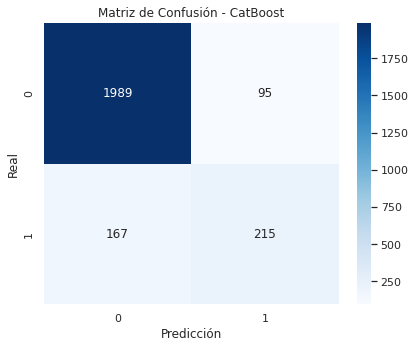

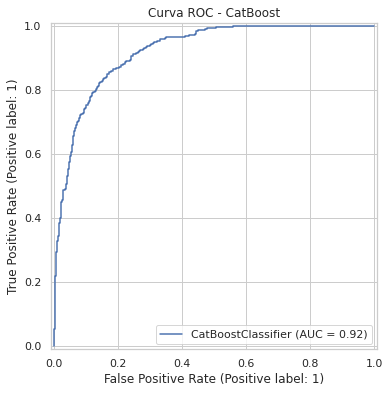

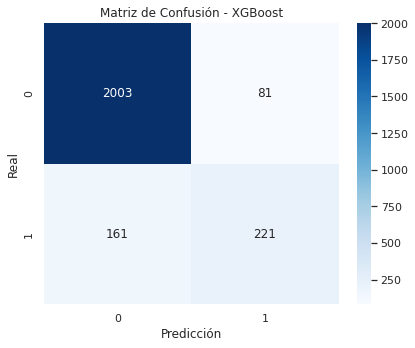

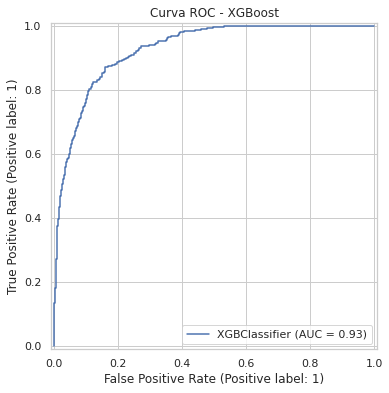

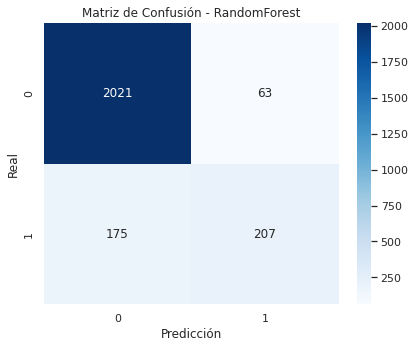

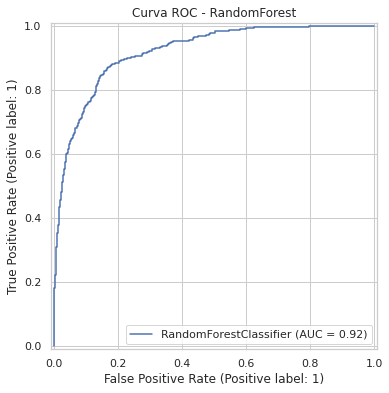

In [21]:
# Evaluar cada modelo sobre el conjunto de test
plot_confusion_and_roc(cat_model, X_test, y_test, "CatBoost")
plot_confusion_and_roc(xgb_model, X_test, y_test, "XGBoost")
plot_confusion_and_roc(rf_model, X_test, y_test, "RandomForest")